<a target="_blank" href="https://colab.research.google.com/github/jackma-00/house-price-prediction/blob/main/experiments/3_house_price_training_pipeline.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# <span style="font-width:bold; font-size: 3rem; color:#333;">Training Pipeline</span>

Install packages

In [21]:
!pip install hopsworks[python]

### <span style='color:#ff5f27'> Imports

In [22]:
import os
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error, r2_score
import hopsworks
from hopsworks.hsfs.builtin_transformations import label_encoder
from hopsworks import udf
from hsml.schema import Schema
from hsml.model_schema import ModelSchema

import warnings
warnings.filterwarnings("ignore")

### <span style='color:#ff5f27'> Connect to Hopsworks Feature Store

In [23]:
# If you haven't set the env variable 'HOPSWORKS_API_KEY', then uncomment the next line and enter your API key
os.environ["HOPSWORKS_API_KEY"] = ""
proj = hopsworks.login()
fs = proj.get_feature_store()

Connection closed.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1158295


In [24]:
# Retrieve feature groups
properties_fg = fs.get_feature_group(name="properties", version=1)
omi_fg = fs.get_feature_group(name="omi", version=1)

### <span style='color:#ff5f27'> Feature View Creation and Retrieving

### Evaluating candidate features

Numerical features:
* agencyid
* bedroomsnumber
* buildingyear
* codcom
* gsm
* surface
* latitude
* longitude

Boolean features:
* isluxury -> bool
* isnew -> bool
* on_the_market -> bool
* zeroenergybuilding -> bool

Categorical features:
* airconditioning -> 15 string
* bathrooms -> 5 string
* city -> 99 string
* condition -> 4 string
* energyclass -> 11 string
* ga4heating -> 2 string
* garage -> 30 string
* heatingtype -> 83 string
* pricerange -> 6 string
* rooms -> 7 string
* (?) floor
* (?) floors

Prediction label:
* price -> label










In [25]:
selected_features = properties_fg.select([
    # Numerical
    "agencyid",
    "bedroomsnumber",
    "buildingyear",
    "codcom",
    "gsm",
    "surface",
    "latitude",
    "longitude",
    # Boolean
    "isluxury",
    "isnew",
    "on_the_market",
    "zeroenergybuilding",
    # Categorical
    "airconditioning",
    "bathrooms",
    "city",
    "condition",
    "energyclass",
    "ga4heating",
    "garage",
    "heatingtype",
    "pricerange",
    "rooms",
    # Label
    "price",
])
selected_features.show(5)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.00s) 


,agencyid,bedroomsnumber,buildingyear,codcom,gsm,surface,latitude,longitude,isluxury,isnew,...,bathrooms,city,condition,energyclass,ga4heating,garage,heatingtype,pricerange,rooms,price
0,169110.0,3.0,2023.0,26086.0,181.0,253,45.6674,12.24400,True,False,...,3,Treviso,Nuovo / In costruzione,A2,Autonomo,1 in box privato/box in garage,"autonomo, a pavimento",oltre 500.000 &euro;,4,1520000.0
1,137414.0,2.0,2014.0,58091.0,55.0,80,41.9075,12.67400,False,True,...,2,Roma,Buono / Abitabile,C,Centralizzato,1 in box privato/box in garage,"centralizzato, a radiatori, alimentato a gas",150.001 - 200.000 &euro;,3,179000.0
2,414251.0,3.0,1997.0,58091.0,229.0,90,41.8467,12.42340,False,False,...,2,Roma,Buono / Abitabile,G,Autonomo,"1 in box privato/box in garage, 1 in parcheggi...","autonomo, a radiatori, alimentato a metano",300.001 - 500.000 &euro;,4,305000.0
3,69846.0,2.0,2006.0,37006.0,34.0,90,44.5046,11.30470,False,True,...,1,Bologna,Da ristrutturare,G,Centralizzato,1 in box privato/box in garage,"centralizzato, a radiatori, alimentato a metano",300.001 - 500.000 &euro;,4,315000.0
4,146766.0,3.0,1970.0,15146.0,25.0,141,45.4676,9.13607,False,True,...,2,Milano,Buono / Abitabile,G,Centralizzato,1 in box privato/box in garage,"centralizzato, a radiatori, alimentato a metano",oltre 500.000 &euro;,4,570000.0


In [26]:
# Defining a one to one transformation function.
@udf(return_type=int, drop="feature")
def bool_to_int(feature):
    return pd.Series(
        [1 if data else 0 for data in feature]
    )

feature_view = fs.get_or_create_feature_view(
    name="house_price_fv",
    description="Read from properties and omi feature groups",
    version=1,
    labels=["price"],
    query=selected_features,
    transformation_functions=[
        bool_to_int(
            "isluxury"
        ),
        bool_to_int(
            "isnew"
        ),
        bool_to_int(
            "on_the_market"
        ),
        bool_to_int(
            "zeroenergybuilding"
        ),
        label_encoder(
            "airconditioning"
        ),
        label_encoder(
            "bathrooms"
        ),
        label_encoder(
            "city"
        ),
        label_encoder(
            "condition"
        ),
        label_encoder(
            "energyclass"
        ),
        label_encoder(
            "ga4heating"
        ),
        label_encoder(
            "garage"
        ),
        label_encoder(
            "heatingtype"
        ),
        label_encoder(
            "pricerange"
        ),
        label_encoder(
            "rooms"
        ),
    ],
)

Feature view created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/1158295/fs/1148998/fv/house_price_fv/version/1


### <span style='color:#ff5f27'> Split the training data into train/test data sets

In [27]:
X_train, X_test, y_train, y_test = feature_view.train_test_split(test_size=0.2)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.95s) 


In [28]:
X_train

,agencyid,bedroomsnumber,buildingyear,codcom,gsm,surface,latitude,longitude,bool_to_int_isluxury_,bool_to_int_isnew_,...,label_encoder_airconditioning_,label_encoder_bathrooms_,label_encoder_city_,label_encoder_condition_,label_encoder_energyclass_,label_encoder_ga4heating_,label_encoder_garage_,label_encoder_heatingtype_,label_encoder_pricerange_,label_encoder_rooms_
0,169110.0,3.0,2023.0,26086.0,181.0,253,45.6674,12.2440,1,0,...,4,3,88,2,3,0,0,1,5,4
1,137414.0,2.0,2014.0,58091.0,55.0,80,41.9075,12.6740,0,1,...,2,2,77,0,7,1,0,58,1,3
2,414251.0,3.0,1997.0,58091.0,229.0,90,41.8467,12.4234,0,0,...,5,2,77,0,11,0,1,15,3,4
3,69846.0,2.0,2006.0,37006.0,34.0,90,44.5046,11.3047,0,1,...,4,1,11,1,11,1,0,61,3,4
6,34721.0,3.0,2008.0,58057.0,1229.0,80,41.7636,12.6110,0,0,...,5,2,50,3,6,0,0,15,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11200,182418.0,2.0,1960.0,58091.0,201.0,85,41.8888,12.5671,0,0,...,5,2,77,3,11,0,11,15,2,3
11201,41685.0,3.0,1960.0,108033.0,279.0,150,45.5853,9.2808,0,0,...,5,2,56,0,11,1,13,58,3,4
11202,123554.0,3.0,2023.0,36023.0,216.0,140,44.6381,10.9528,0,0,...,10,2,54,2,5,0,1,38,3,5
11203,95686.0,3.0,1979.0,49009.0,123.0,136,43.5333,10.3139,0,0,...,4,2,47,0,8,0,11,15,3,5


In [29]:
y_train

,price
0,1520000.0
1,179000.0
2,305000.0
3,315000.0
6,199000.0
...,...
11200,219000.0
11201,490000.0
11202,474000.0
11203,350000.0


### <span style='color:#ff5f27'> Modeling

In [30]:
# Creating an instance of the XGBoost Regressor
xgb_regressor = XGBRegressor()

# Fitting the XGBoost Regressor to the training data
xgb_regressor.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [31]:
# Predicting target values on the test set
y_pred = xgb_regressor.predict(X_test)

# Calculating Mean Squared Error (MSE) using sklearn
mse = mean_squared_error(y_test.iloc[:,0], y_pred)
print("MSE:", mse)

# Calculating R squared using sklearn
r2 = r2_score(y_test.iloc[:,0], y_pred)
print("R squared:", r2)

MSE: 9686852817.7938
R squared: 0.9030876518289802


In [32]:
df = y_test
df['predicted_price'] = y_pred
df = df.sort_values(by="price").reset_index(drop=True)
df.head(5)

,price,predicted_price
0,29000.0,89532.109375
1,31000.0,40553.867188
2,35000.0,80484.390625
3,39000.0,60168.414062
4,45000.0,78584.406250


In [33]:
# Creating a directory for the model artifacts if it doesn't exist
model_dir = "house_price_model"
if not os.path.exists(model_dir):
    os.mkdir(model_dir)
images_dir = model_dir + "/images"
if not os.path.exists(images_dir):
    os.mkdir(images_dir)

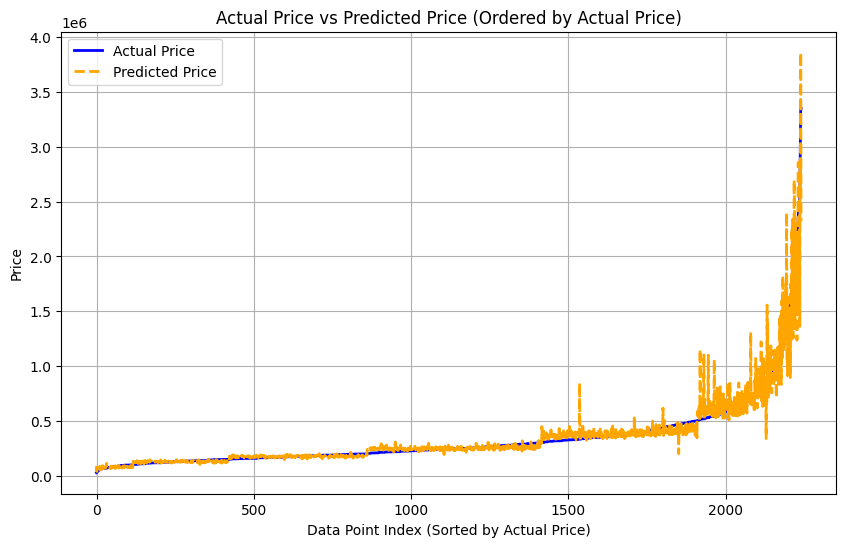

In [34]:
# Plot
plt.figure(figsize=(10, 6))  # Set figure size
plt.plot(df.index, df["price"], label="Actual Price", color='blue', linewidth=2)
plt.plot(df.index, df["predicted_price"], label="Predicted Price", color='orange', linestyle='--', linewidth=2)

# Labels, Title, and Legend
plt.xlabel("Data Point Index (Sorted by Actual Price)")
plt.ylabel("Price")
plt.title("Actual Price vs Predicted Price (Ordered by Actual Price)")
plt.legend()

# Grid
plt.grid(True)

# Save the plot to the desired file path
os.makedirs(images_dir, exist_ok=True)  # Create the directory if it doesn't exist
file_path = images_dir + "/price_hindcast.png"
plt.savefig(file_path, format='png', dpi=300, bbox_inches='tight')

# Display the plot
plt.show()

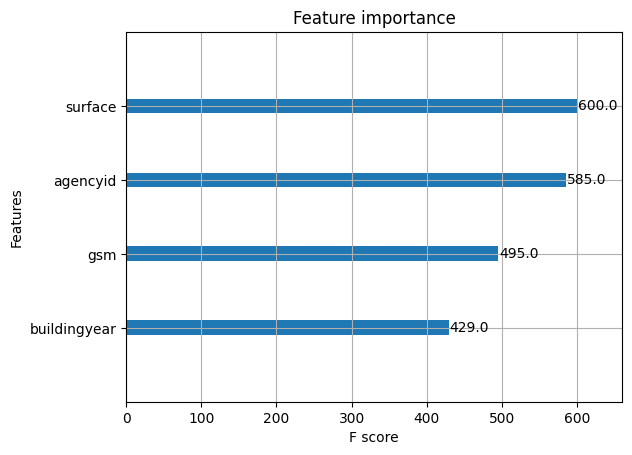

In [35]:
# Plotting feature importances using the plot_importance function from XGBoost
plot_importance(xgb_regressor, max_num_features=4)
feature_importance_path = images_dir + "/feature_importance.png"
plt.savefig(feature_importance_path)
plt.show()

### <span style='color:#ff5f27'> Model Registry

In [36]:
# Creating input and output schemas using the 'Schema' class for features (X) and target variable (y)
input_schema = Schema(X_train)
output_schema = Schema(y_train)

# Creating a model schema using 'ModelSchema' with the input and output schemas
model_schema = ModelSchema(input_schema=input_schema, output_schema=output_schema)

# Converting the model schema to a dictionary representation
schema_dict = model_schema.to_dict()

In [37]:
# Saving the XGBoost regressor object as a json file in the model directory
xgb_regressor.save_model(model_dir + "/model.json")

In [38]:
res_dict = {
        "MSE": str(mse),
        "R squared": str(r2),
    }

In [40]:
mr = proj.get_model_registry()

# Creating a Python model in the model registry named 'air_quality_xgboost_model'

aq_model = mr.python.create_model(
    name="house_price_xgboost_model",
    metrics= res_dict,
    model_schema=model_schema,
    input_example=X_test.sample().values,
    description="Italian house price predictor",
)

# Saving the model artifacts to the 'air_quality_model' directory in the model registry
aq_model.save(model_dir)

  0%|          | 0/6 [00:00<?, ?it/s]

Uploading: 0.000%|          | 0/520440 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/169388 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/18838 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/139 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/1940 elapsed<00:00 remaining<?

Model created, explore it at https://c.app.hopsworks.ai:443/p/1158295/models/house_price_xgboost_model/1


Model(name: 'house_price_xgboost_model', version: 1)